In [1]:
# Data cleaning, transformations, and LSTM architecture derived from https://www.kaggle.com/shivanandmn/cnn-lstm-pytorch-riiid

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
train_df = pd.read_csv("data/train.csv", low_memory=False, nrows=1000000)

In [4]:
train_df = train_df.sort_values(['timestamp'], ascending=True).reset_index(drop=True)
train_df.drop(['timestamp', 'content_type_id'], axis=1, inplace=True)

In [5]:
X_test_df = pd.DataFrame()
for i in range(4):
    last_records = train_df.drop_duplicates('user_id', keep='last')
    train_df = train_df[~train_df.index.isin(last_records.index)]
    X_test_df = X_test_df.append(last_records)

In [6]:
X_train_df = pd.DataFrame()
for i in range(15):
    last_records = train_df.drop_duplicates('user_id', keep = 'last')
    train_df = train_df[~train_df.index.isin(last_records.index)]
    X_train_df = X_train_df.append(last_records)

In [7]:
results_c = train_df[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c.columns = ["answered_correctly_content_mean"]
results_u = train_df[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum', 'count'])
results_u.columns = ["answered_correctly_user_mean", 'sum_correct', 'count']
result_time_mean = train_df.prior_question_elapsed_time.mean()

In [8]:
y_train = X_train_df['answered_correctly'].tolist()
X_train_df = X_train_df.drop(['answered_correctly'], axis=1)

y_test = X_test_df['answered_correctly'].to_list()
X_test_df = X_test_df.drop(['answered_correctly'], axis=1)

In [9]:
lencoder = LabelEncoder()

X_train_df['prior_question_had_explanation'].fillna(False, inplace=True)
X_train_df['prior_question_elapsed_time'].fillna(result_time_mean, inplace=True)

X_test_df['prior_question_had_explanation'].fillna(False, inplace = True)
X_test_df['prior_question_elapsed_time'].fillna(result_time_mean, inplace=True)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

In [11]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [12]:
device = 'cpu'

In [13]:
class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, n_layers):
        super(LSTMBinaryClassifier, self).__init__()

        self.input_size = input_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(self.input_size, self.input_size, num_layers=self.n_layers, batch_first=True)
        self.fc1 = nn.Linear(self.input_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.drop = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self,x):
        hidden = self.init_hidden(x.shape[0])
        x, _ = self.lstm(x, hidden)
        x = self.drop(self.relu(self.fc1(x)))
        x = self.drop(self.relu(self.fc2(x)))
        return x

    def init_hidden(self, batch_size):
        hidden = (torch.zeros((self.n_layers, batch_size, self.input_size)).to(device),
                  torch.zeros((self.n_layers, batch_size, self.input_size)).to(device))
        return hidden

In [14]:
model = LSTMBinaryClassifier(input_size=X_train.shape[2], n_layers=3)
model.to(device)

LSTMBinaryClassifier(
  (lstm): LSTM(7, 7, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=7, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
)

In [15]:
BATCH_SIZE = 32
NUM_EPOCHS = 240
LEARNING_RATE = 0.001

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [17]:
model.train()
epoch_losses = []
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for batch_idx in range(0, X_train.shape[0], BATCH_SIZE):
        batch = X_train[batch_idx * BATCH_SIZE:(batch_idx + 1) * BATCH_SIZE]
        if batch.shape[0] <= 0:
            continue
        batch = torch.Tensor(batch).view(BATCH_SIZE, 1, -1).to(device)

        target = y_train[batch_idx * BATCH_SIZE:(batch_idx + 1) * BATCH_SIZE]
        target = torch.Tensor(target).view(BATCH_SIZE, 1, -1).long().to(device)

        optimizer.zero_grad()

        pred = model(batch).permute(0, 2, 1)

        target = target.type_as(pred)

        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_epoch_loss = total_loss / X_train.shape[0]
    epoch_losses.append(avg_epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {(epoch + 1):03} | Loss: {avg_epoch_loss}')

Epoch 010 | Loss: 0.000659835182901514
Epoch 020 | Loss: 0.0006576071495922018
Epoch 030 | Loss: 0.0006537745273741621
Epoch 040 | Loss: 0.0006546999713730301
Epoch 050 | Loss: 0.0006505637915683618
Epoch 060 | Loss: 0.0006495301611822596
Epoch 070 | Loss: 0.0006476096300272998
Epoch 080 | Loss: 0.0006472484926416484
Epoch 090 | Loss: 0.0006438647813145941
Epoch 100 | Loss: 0.0006409467052634505
Epoch 110 | Loss: 0.0006424831049577108
Epoch 120 | Loss: 0.0006386458346512584
Epoch 130 | Loss: 0.0006364196342694112
Epoch 140 | Loss: 0.0006399033781519623
Epoch 150 | Loss: 0.0006361807849523555
Epoch 160 | Loss: 0.000641660688733456
Epoch 170 | Loss: 0.0006392513880624962
Epoch 180 | Loss: 0.0006420134372413773
Epoch 190 | Loss: 0.0006364732759698661
Epoch 200 | Loss: 0.0006345213731831508
Epoch 210 | Loss: 0.0006364943384628238
Epoch 220 | Loss: 0.0006329800612432843
Epoch 230 | Loss: 0.0006311150376011194
Epoch 240 | Loss: 0.0006375338617107258


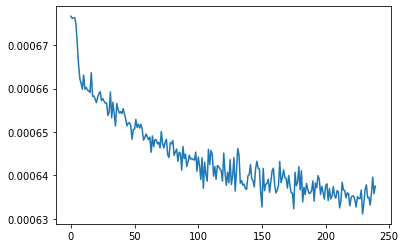

In [18]:
plt.plot(epoch_losses)

In [19]:
model.eval()
num_correct = 0
for i in range(X_test.shape[0]):
    sample = X_test[i]
    sample = torch.Tensor(sample).view(1, 1, -1).to(device)
    pred = model(sample).permute(0, 2, 1).item()
    if (pred > 0.5 and y_test[i] == 1) or (pred < 0.5 and y_test[i] == 0):
        num_correct += 1
print(f'Test Accuracy: {num_correct / X_test.shape[0]}')

Test Accuracy: 0.544062806673209
